<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MNIST-Deep-Taylor-Decomposition" data-toc-modified-id="MNIST-Deep-Taylor-Decomposition-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MNIST Deep Taylor Decomposition</a></span></li></ul></div>

# MNIST Deep Taylor Decomposition

This is an example hpw to use the code in `deeptaylor.py`

We start with creating dataloaders for MNIST

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torchvision
import torchvision.transforms as transforms
import torch
from matplotlib import pyplot as plt
        
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=2)

Now, we create our model

In [3]:
from lrp import *
from trainable_net import *


class DigitNet(ExplainableModel):
    """
    Rebuilt of cifar10utils.Net with deep taylor support
    """
    def __init__(self):
        layers = [
            ConvRelu(1, 5, 5), # 24x24
            MaxPool(2, 2), # 12x12
            ConvRelu(5, 16, 5), # 8x8
            MaxPool(2, 2), # 4x4
            LinearRelu(4*4*16, 100),
            Linear(100, 10)
        ]
        super().__init__(layers, -1, 1)
        
        # Because pytorch is weird, the submodels cannot be stored in a list
        self.l1 = layers[0]
        self.l2 = layers[1]
        self.l3 = layers[2]
        self.l4 = layers[3]
        self.l5 = layers[4]
        self.l6 = layers[5]
        

digit_net = DigitNet()
# digit_net.train(3, trainloader)
digit_net.load("digitnet")

accuracy = digit_net.accuracy(testloader)
print("Accuracy:", accuracy)

Accuracy: 0.9844


And generate some beautiful heatmaps.

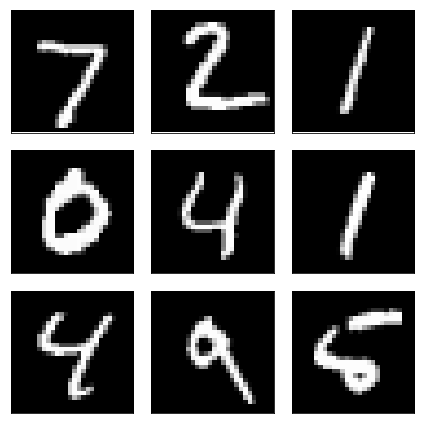

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


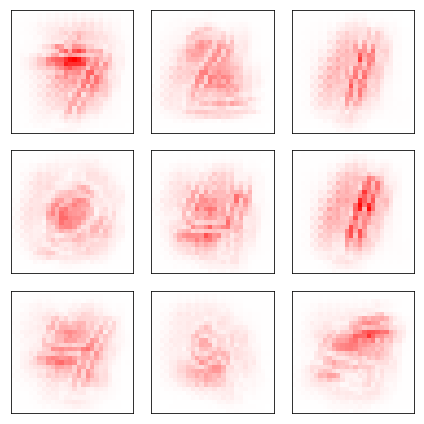

In [4]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images[:9], labels[:9]

digit_net.forward(images)

h_dtd = digit_net.deeptaylor(images, one_hot(labels))


def plot_heatmaps(X, Y=None, scale=1.5):
    X *= scale
    X = X.reshape([-1, 28, 28])
    rows, cols = int(np.sqrt(len(X))), int(np.ceil(np.sqrt(len(X))))
    fig, axes = plt.subplots(nrows=rows, ncols=cols, squeeze=False,
                            figsize=(2*cols,2*rows,))
    for i, x in enumerate(X):
        row = int(i/cols)
        col = i % cols
        ax = axes[row][col]
        if Y is not None:
            y = Y[i]
            ax.set_title(np.argmax(y))
        ax.tick_params(
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off
        img = np.ones([28,28,3])
        red = np.where(x>0,x,0)
        blue = np.where(x>0,0,-x)
        img[:,:,0] -= 4*blue
        img[:,:,1] -= 4*(blue + red)
        img[:,:,2] -= 4*red
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

    
def plot_digits(X, Y=None):
    X = X.reshape([-1, 28, 28])
    rows, cols = int(np.sqrt(len(X))), int(np.ceil(np.sqrt(len(X))))
    fig, axes = plt.subplots(nrows=rows, ncols=cols, squeeze=False,
                            figsize=(2*cols,2*rows,))
    for i, x in enumerate(X):
        row = int(i/cols)
        col = i % cols
        ax = axes[row][col]
        if Y is not None:
            y = Y[i]
            ax.set_title(np.argmax(y))
        ax.tick_params(
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off
        ax.imshow(x, cmap='gray')
    plt.tight_layout()
    plt.show()

plot_digits(images)
plot_heatmaps(h_dtd.detach())

Just for fun, also the gradient times input heatmaps

/Users/nielswarncke/Documents/pytorch-tuts/cifar10_experiments/trainable_net.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(images, requires_grad=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping in

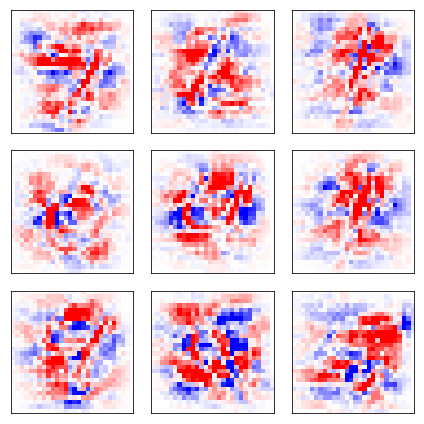

In [5]:
h_itg = input_times_gradient(digit_net, images, one_hot(labels))
plot_heatmaps(h_itg.sum(1).detach())